# Progetto BigData:
calcolare, per ogni categoria, le seguenti informazioni:

- Numero di articoli

- Numero medio di parole utilizzate

- Numero massimo di parole presenti nell’articolo più lungo

- Numero minimo di parole presenti nell’articolo più corto

- Per ogni categoria, individuare la nuvola di parole più rappresentativa

Dopo aver svolto l’analisi richiesta, è necessario addestrare e testare un classificatore testuale capace di classificare gli articoli (secondo le categorie presenti nel dataset) che saranno in futuro inseriti.

Per le attività precedentemente richieste, lo studente svolga il tutto considerando prima la colonna summary, poi la colonna documents, così da confrontare i risultati ottenuti con le due differenti colonne e verificare quale dei due classificatori ha maggiore accuratezza in termini di classificazione



In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
import pandas as pd
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')

--2024-05-09 06:48:48--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.154.76, 3.5.224.142
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.154.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘wikipedia.csv’

wikipedia.csv       100%[===================>] 956.99M  11.6MB/s    in 72s     

2024-05-09 06:50:01 (13.3 MB/s) - ‘wikipedia.csv’ saved [1003477941/1003477941]



In [0]:
spark_df = spark.createDataFrame(dataset)
spark_df = spark_df.drop("Unnamed: 0")
#spark_df.write.saveAsTable("wikipedia")

# data exploration

In [0]:
spark_df.show(5)

+--------------------+--------------------+--------------------+---------+
|               title|             summary|           documents|categoria|
+--------------------+--------------------+--------------------+---------+
|           economics|economics () is a...|economics () is a...|economics|
|index of economic...|this aims to be a...|this aims to be a...|economics|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|economic impact a...|an economic impac...|an economic impac...|economics|
|      economic trend|economic trend ma...|economic trend ma...|economics|
+--------------------+--------------------+--------------------+---------+
only showing top 5 rows



In [0]:
#quanti record?
spark_df.count()

153232

In [0]:
# numero di valori nulli per ogni categoria
from pyspark.sql.functions import col, sum as sql_sum

null_counts = spark_df.groupBy("categoria").agg(
    sql_sum(col("summary").isNull().cast("int")).alias("nan_summary"),
    sql_sum(col("documents").isNull().cast("int")).alias("nan_documents")
)

null_counts.show()

+-----------+-----------+-------------+
|  categoria|nan_summary|nan_documents|
+-----------+-----------+-------------+
|  economics|          0|            0|
|   politics|          0|            0|
|    culture|        217|          217|
|    science|         70|           70|
|     sports|          2|            2|
|     energy|         13|           13|
|    finance|        294|          294|
| humanities|        120|          120|
|       pets|          7|            7|
|      trade|          4|            4|
| technology|         13|           13|
|  transport|         19|           19|
|   medicine|         61|           61|
|engineering|          1|            1|
|   research|        107|          107|
+-----------+-----------+-------------+



In [0]:
# rimozione righe con Nan in "summary" o "documents"
spark_df = spark_df.dropna(subset=["summary", "documents"]) 

# - Numero di articoli per ogni categoria

In [0]:
spark_df.groupBy("categoria").count().show() #dataset abbastanza bilanciato

+-----------+-----+
|  categoria|count|
+-----------+-----+
|  economics|10110|
|   politics|11358|
|    culture|10155|
|    science|10166|
|     sports|10066|
|     energy|10033|
|    finance| 9863|
| humanities|10116|
|       pets|10016|
|      trade|10064|
| technology|10082|
|  transport|10111|
|   medicine|10015|
|engineering|10219|
|   research| 9930|
+-----------+-----+



# - Numero medio di parole utilizzate

In [0]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.sql.functions import size
from pyspark.sql import DataFrame


def process_text_column(df, inputCol, tokensCol, numWordsCol) -> DataFrame:
    """
    Funzione per processare una colonna di testo in un DataFrame di PySpark.

    Questa funzione esegue la tokenizzazione del testo e aggiunge una nuova colonna con il numero di parole per ogni documento.

    Args:
        df (DataFrame): DataFrame di PySpark contenente i dati.
        inputCol (str): Nome della colonna di input contenente il testo da processare.
        tokensCol (str): Nome della nuova colonna che conterrà i token.
        numWordsCol (str): Nome della nuova colonna che conterrà il numero di parole per ogni documento.

    Returns:
        DataFrame: DataFrame di PySpark con le nuove colonne aggiunte.
    """

    # tokenizzazione
    tokenizer = Tokenizer(inputCol=inputCol, outputCol=tokensCol)

    df = tokenizer.transform(df)

    # colonna con numero di parole per ogni documento
    df = df.withColumn(numWordsCol, size(df[tokensCol]))

    return df


## summary

In [0]:
spark_df = process_text_column(spark_df, "summary", "tokens_summary", "num_words_summary")

In [0]:
from pyspark.sql.functions import mean, round
spark_df.groupBy("categoria").agg(round(mean("num_words_summary"),1)).show()

+-----------+--------------------------------+
|  categoria|round(avg(num_words_summary), 1)|
+-----------+--------------------------------+
|  economics|                           112.4|
|   politics|                           177.3|
|    culture|                           102.8|
|    science|                           105.6|
|     sports|                            80.7|
|     energy|                            96.9|
|    finance|                           114.6|
| humanities|                            87.3|
|       pets|                            72.4|
|      trade|                           107.9|
| technology|                           103.5|
|  transport|                            86.0|
|   medicine|                            99.6|
|engineering|                            88.9|
|   research|                            91.8|
+-----------+--------------------------------+



## documents


In [0]:
spark_df = process_text_column(spark_df, "documents", "tokens_documents", "num_words_documents")


In [0]:
spark_df.groupBy("categoria").agg(round(mean("num_words_documents"),1)).show()

+-----------+----------------------------------+
|  categoria|round(avg(num_words_documents), 1)|
+-----------+----------------------------------+
|  economics|                             984.2|
|   politics|                            1515.7|
|    culture|                             653.9|
|    science|                            1875.6|
|     sports|                             602.1|
|     energy|                             587.5|
|    finance|                            1909.9|
| humanities|                            1059.7|
|       pets|                             423.1|
|      trade|                             641.2|
| technology|                             889.2|
|  transport|                             629.8|
|   medicine|                             792.2|
|engineering|                             725.1|
|   research|                             701.9|
+-----------+----------------------------------+



# - Numero massimo e minimo di parole presenti negli articoli

In [0]:
from pyspark.sql import functions as F

def show_min_max(df, input_col, title_col) -> None:
    """
    Funzione per mostrare i valori minimo e massimo di una colonna specifica raggruppati per categoria in un DataFrame di PySpark.

    Questa funzione calcola e mostra i valori minimo e massimo della colonna specificata per ogni categoria.

    Args:
        df (DataFrame): DataFrame di PySpark contenente i dati.
        input_col (str): Nome della colonna di input da cui calcolare i valori minimo e massimo.
        title_col (str): Titolo da utilizzare per le nuove colonne nel DataFrame di output.
    """

    result = spark_df.groupBy("categoria").agg(F.max(input_col).alias("max_words" + "_"+ title_col), F.min(input_col).alias("min_words" + "_"+ title_col))
    result.show()

## summary


In [0]:
show_min_max(spark_df, "num_words_summary", "summary")

+-----------+-----------------+-----------------+
|  categoria|max_words_summary|min_words_summary|
+-----------+-----------------+-----------------+
|  economics|             1086|                7|
|   politics|              677|                5|
|    culture|             1110|                6|
|    science|              806|               10|
|     sports|              968|                3|
|     energy|              851|                7|
|    finance|             1367|                3|
| humanities|             1543|                4|
|       pets|              779|                9|
|      trade|             1343|                6|
| technology|              733|                2|
|  transport|             1978|                4|
|   medicine|             1293|                1|
|engineering|             1231|                6|
|   research|              811|                6|
+-----------+-----------------+-----------------+



## documents

In [0]:
show_min_max(spark_df, "num_words_documents", "documents")

+-----------+-------------------+-------------------+
|  categoria|max_words_documents|min_words_documents|
+-----------+-------------------+-------------------+
|  economics|              24022|                 10|
|   politics|              20140|                 11|
|    culture|              15538|                 11|
|    science|              29419|                 15|
|     sports|              19227|                 14|
|     energy|              23223|                  9|
|    finance|              33479|                  3|
| humanities|              23198|                  7|
|       pets|              13222|                 12|
|      trade|              19275|                 16|
| technology|              18144|                  2|
|  transport|              22150|                 10|
|   medicine|              18422|                 12|
|engineering|              11856|                  8|
|   research|              27223|                 17|
+-----------+---------------

## Check

In [0]:
# controllo del documento della categoria "medicine" che ha solo una parola in "summary"

def show_min_doc(df, input_col, category) -> None:
    """
    Funzione per mostrare il documento con il valore minimo in una colonna specifica per una determinata categoria in un DataFrame di PySpark.

    Questa funzione filtra il DataFrame per la categoria specificata, ordina i risultati in base alla colonna di input e mostra il primo risultato (minimo).

    Args:
        df (DataFrame): DataFrame di PySpark contenente i dati.
        input_col (str): Nome della colonna di input da usare per l'ordinamento.
        category (str): Categoria da utilizzare per filtrare il DataFrame.
    """

    result = df.filter(df.categoria == category).orderBy(input_col).select("summary", "documents").first()
    print("Summary: ", result.summary)
    print("\nDocuments: ", result.documents)

show_min_doc(spark_df, "num_words_summary", "medicine")
#il documento si potrebbe eliminare, considerato che non ha "summary", ma decido di tenerlo perchè in "documents" c'è scritto molto

Summary:  }}

Documents:  }} history the hospital was established in 1861 with the name of london christian church hospital. jin xianzhai, the well-known oncologist, set up the first tumor ward in the hospital in 1952. in 1972, the hospital became a specialized cancer hospital with only 341 beds. in 1977, the institute of cancer research was established with eight departments. this institute is a renowned institution dedicated to cancer research, treatment, and prevention. the institute was established by professor jin xianzhai, a prominent chinese oncologist, it originated as the cancer prevention research laboratory within tianjin people's hospital. over the years, it has evolved and expanded its scope, eventually becoming a significant player in the field of oncology. since its inception the tianjin medical university cancer institute and hospital (tmucih) has played a pivotal role in advancing medical expertise in the field of oncology and pathology. tasked by the ministry of healt

# -Nuvola di parole più rappresentative per ogni categoria

In [0]:
!pip install wordcloud

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 6.5 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.ml.feature import StopWordsRemover

def remove_stopwords(df, inputCol, outputCol, more_stopwords=None):
    """
    Funzione per rimuovere le stopwords da una colonna di testo in un DataFrame di PySpark.

    Questa funzione crea un oggetto StopWordsRemover, ottiene la lista di stopwords esistente, aggiunge eventuali stopwords aggiuntive alla lista, imposta la nuova lista di stopwords e applica la trasformazione al DataFrame.

    Args:
        df (DataFrame): DataFrame di PySpark contenente i dati.
        inputCol (str): Nome della colonna di input contenente il testo da cui rimuovere le stopwords.
        outputCol (str): Nome della colonna di output che conterrà il testo senza stopwords.
        more_stopwords (List[str], optional): Lista di stopwords aggiuntive da rimuovere. Default a None.

    Returns:
        DataFrame: DataFrame di PySpark con le stopwords rimosse dalla colonna di testo.
    """

    # definisco StopWordsRemover
    remover = StopWordsRemover(inputCol=inputCol, outputCol=outputCol)

    # lista di stopwords esistente
    stopwords = remover.getStopWords()

    # Se ci sono stopwords aggiuntive, aggiungile alla lista
    if more_stopwords:
        stopwords += more_stopwords

    # nuova lista di stopwords
    remover.setStopWords(stopwords)

    # trasformazione del dataframe
    df = remover.transform(df)

    return df

In [0]:
from pyspark.sql.functions import explode
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(spark_df, column_name) -> None:

    """
    Funzione per generare un wordcloud per ogni categoria in un DataFrame di PySpark.

    Questa funzione divide le parole in ogni riga, le esplode in righe separate, conta le parole per ogni categoria e genera un wordcloud per ogni categoria.

    Args:
        spark_df (DataFrame): DataFrame di PySpark contenente i dati.
        column_name (str): Nome della colonna contenente le parole da visualizzare nel wordcloud.
    """

    # Divisione di ogni parola in riga e esplosione in righe separate
    df_words = spark_df.select(explode(spark_df[column_name]).alias('word'), 'categoria')

    # Conteggio parole per ogni categoria
    df_counts = df_words.groupBy('categoria', 'word').count()

    #funzione che genera colori a random, non troppo chiari a causa dello sfondo bianco 
    def get_color():
        h = int(360.0 * random.random())
        s = int(30.0 + 70.0 * random.random())  # saturazione tra 30% e 100%
        l = int(20.0 + 60.0 * random.random())  # luminosità tra 20% e 80%
        return "hsl({}, {}%, {}%)".format(h, s, l)

    # dizionario per memorizzare i colori per ogni categoria
    category_colors = {}

    # un wordcloud per ogni categoria
    for categoria in df_counts.select('categoria').distinct().rdd.flatMap(lambda x: x).collect():
        df_categoria = df_counts.filter(df_counts.categoria == categoria).toPandas()
        
        # Generazione di un colore casuale per la categoria se non esiste già nel dizionario
        if categoria not in category_colors:
            category_colors[categoria] = get_color()
       
        wc = WordCloud(width=800, height=400, max_words=100, background_color='white', color_func=lambda *args, **kwargs: category_colors[categoria])

        wc.generate_from_frequencies(df_categoria.set_index('word')['count'])
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(categoria)
        plt.show()


## summary

In [0]:
import string

more_stopwords = ["also", "one", "new", "first"] + list(string.punctuation) #rimuovo la punteggiatura
spark_df = remove_stopwords(spark_df, "tokens_summary", "filtered_tokens_summary",more_stopwords=more_stopwords)
spark_df = spark_df.drop("tokens_summary") #colonna tokens non serve più

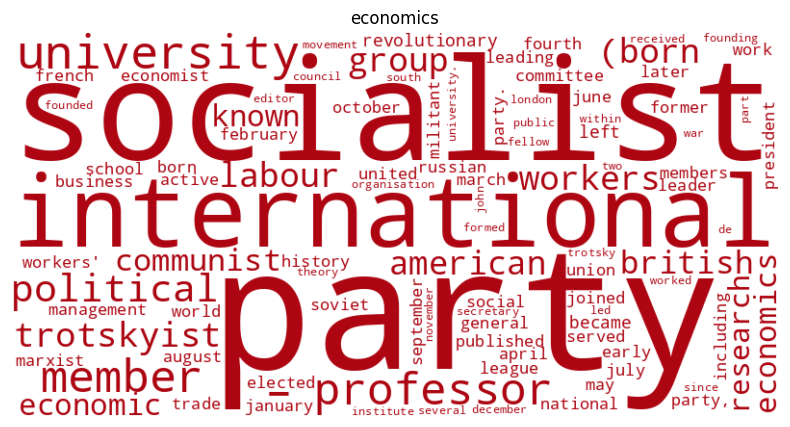

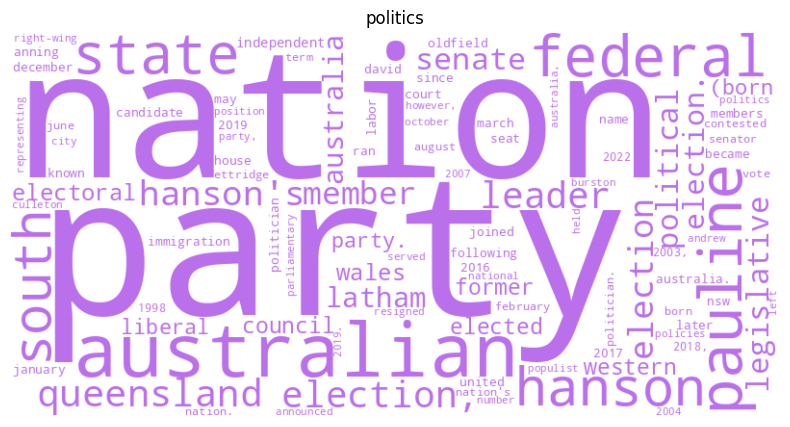

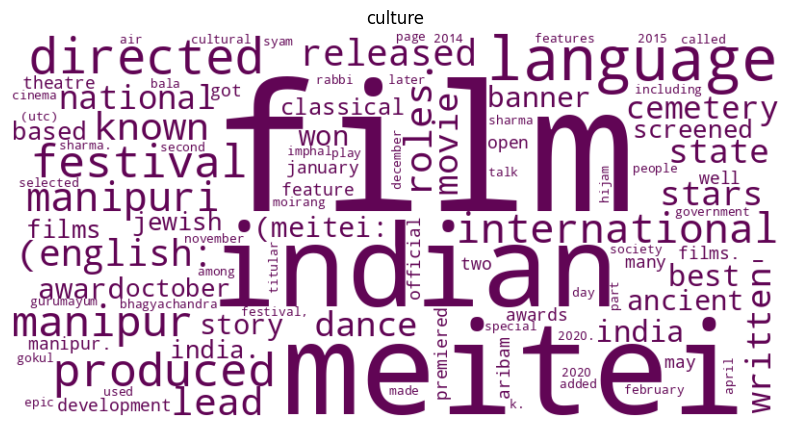

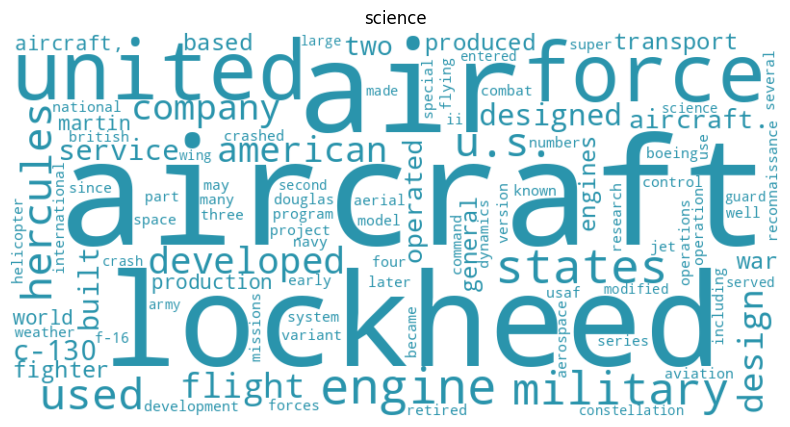

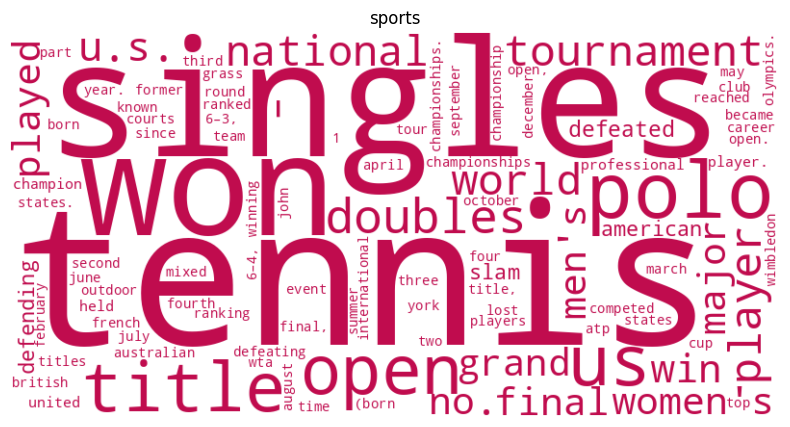

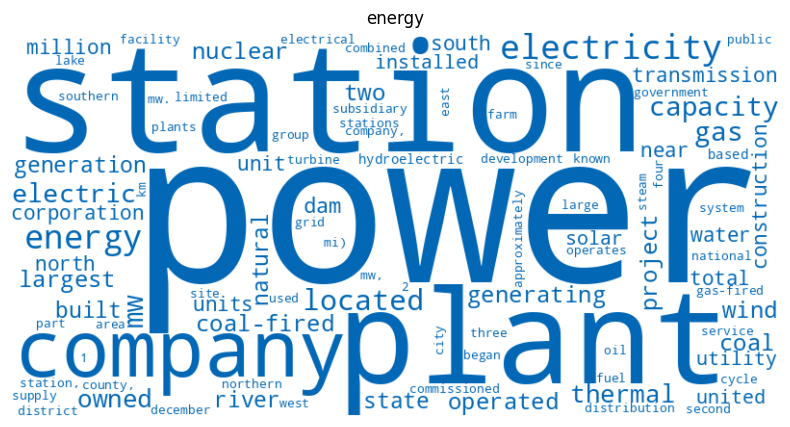

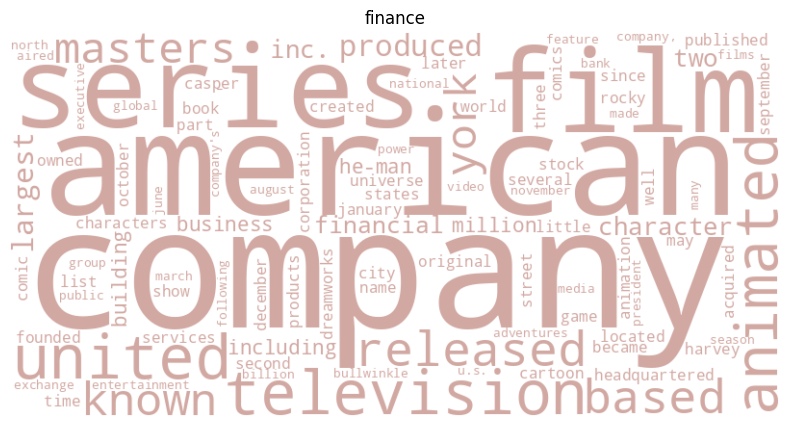

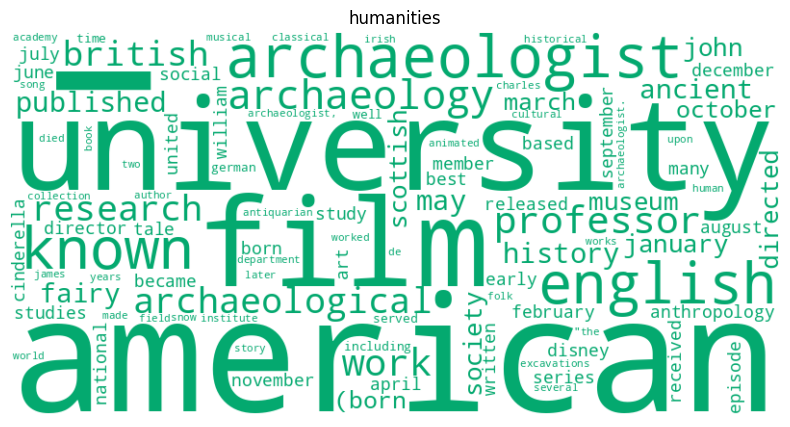

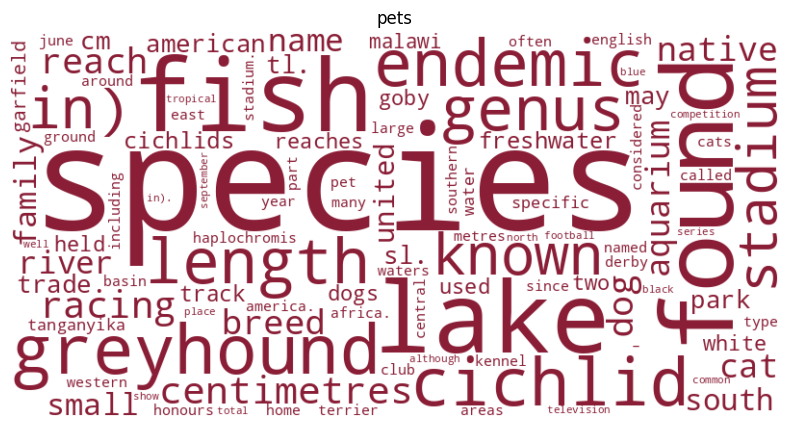

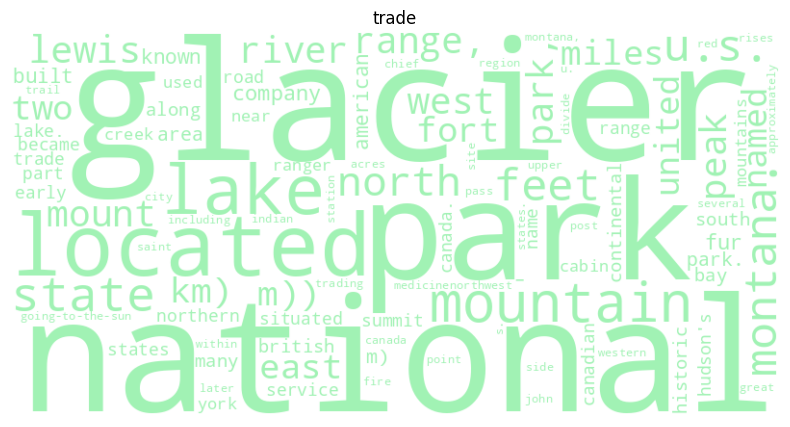

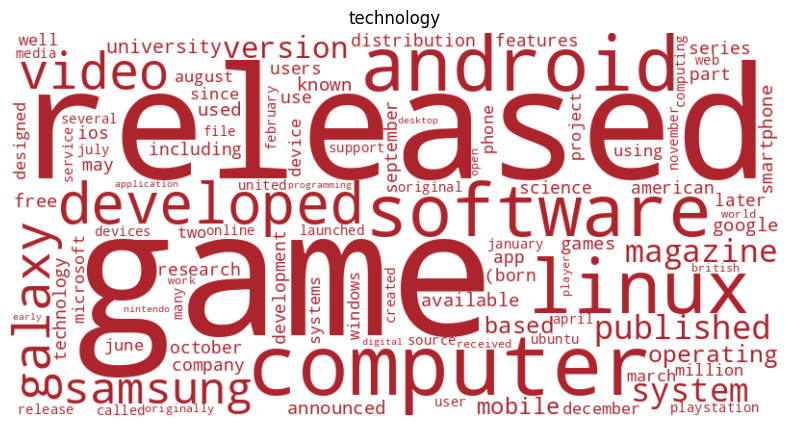

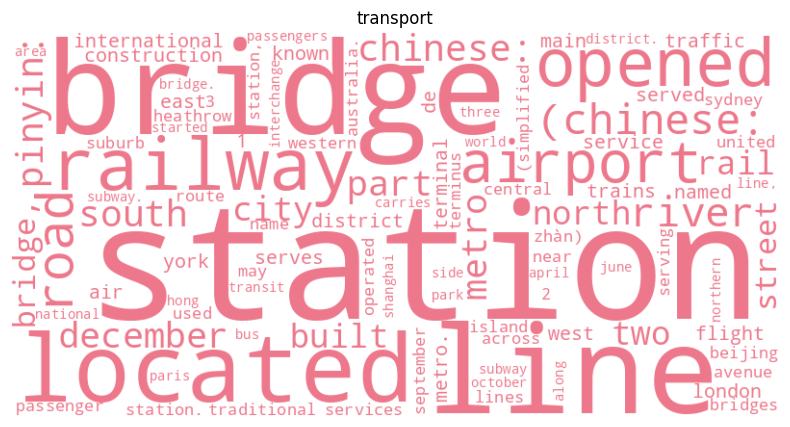

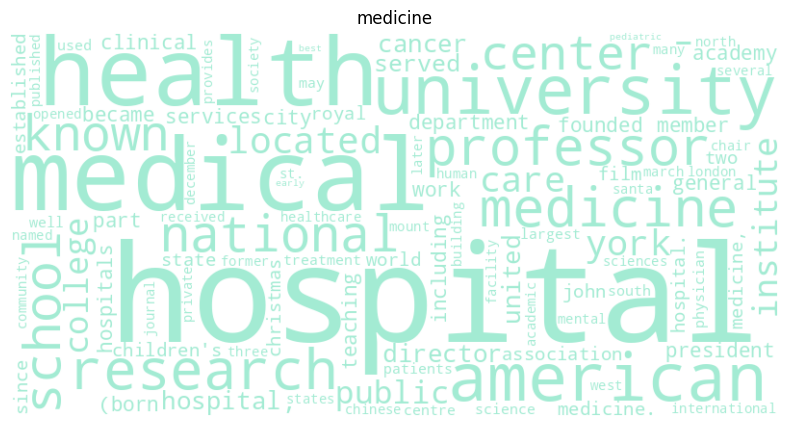

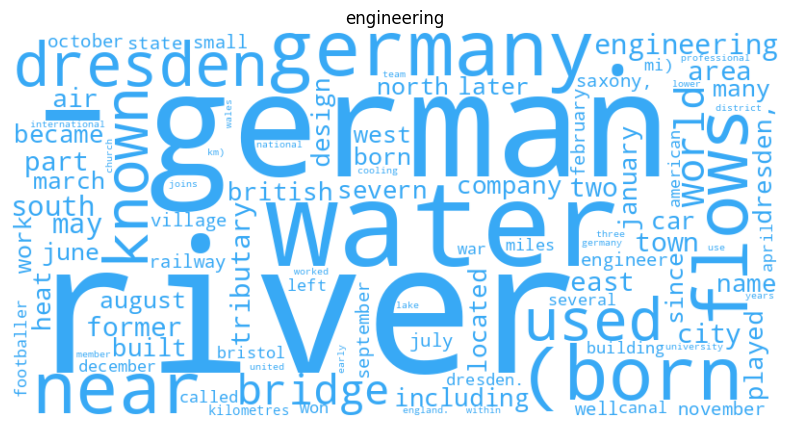

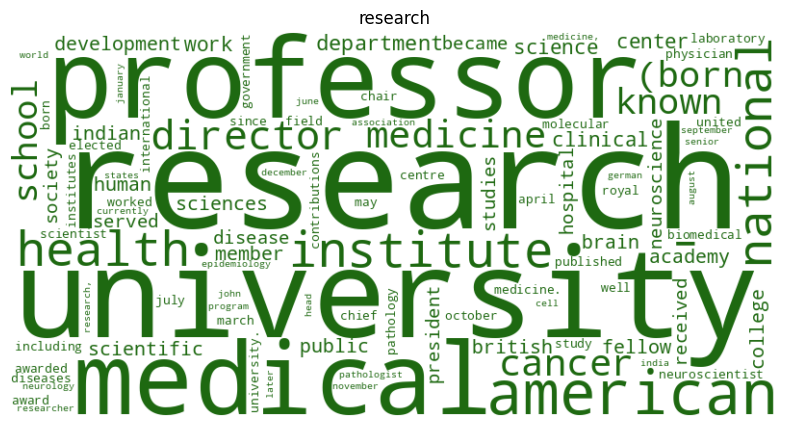

In [0]:
generate_wordcloud(spark_df, 'filtered_tokens_summary')

##documents

In [0]:
spark_df = remove_stopwords(spark_df, "tokens_documents", "filtered_tokens_documents", more_stopwords=more_stopwords)
spark_df = spark_df.drop("tokens_documents") #rimuovo la colonna tokens

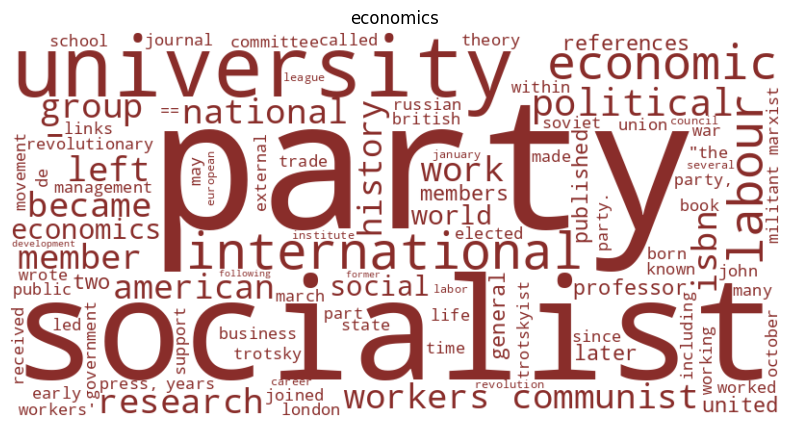

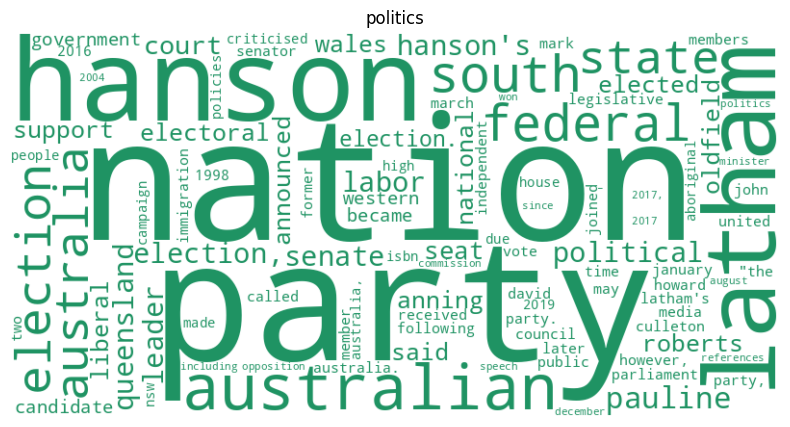

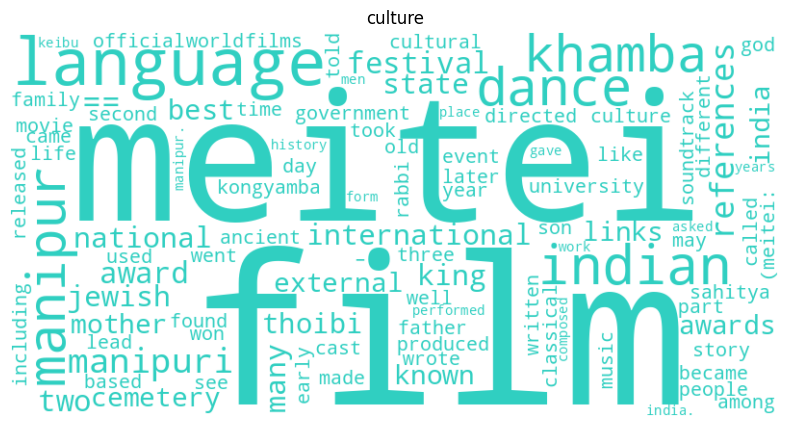

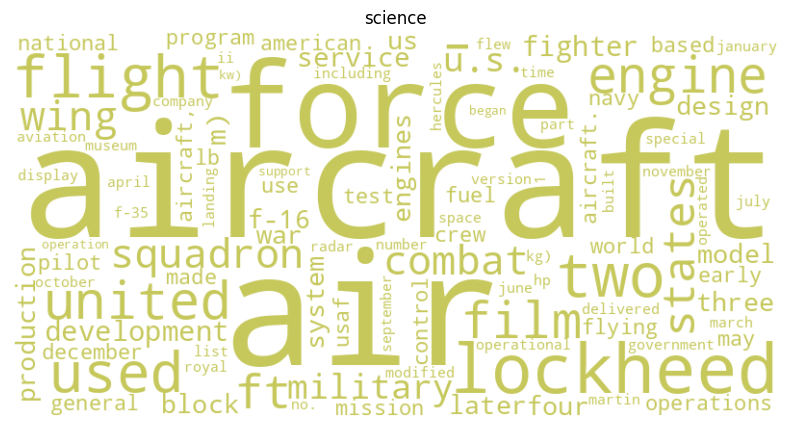

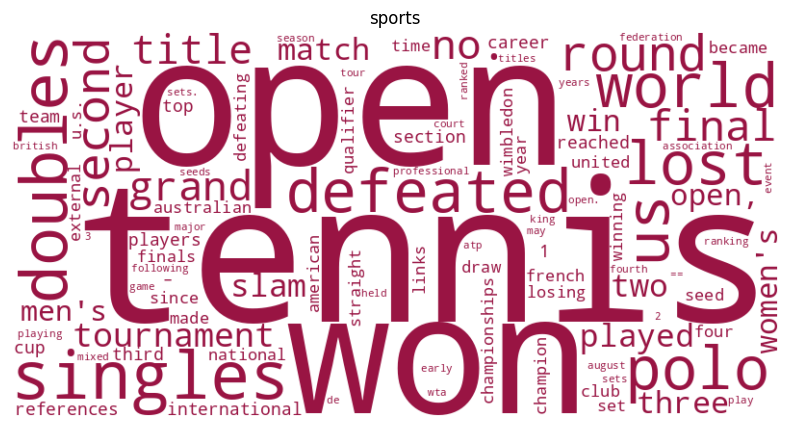

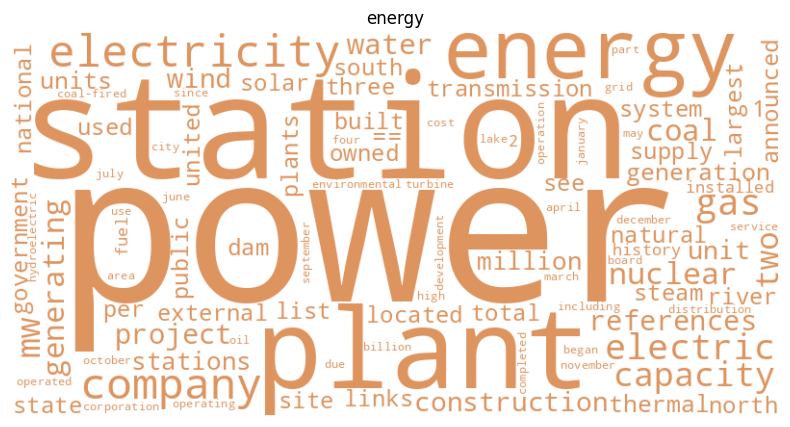

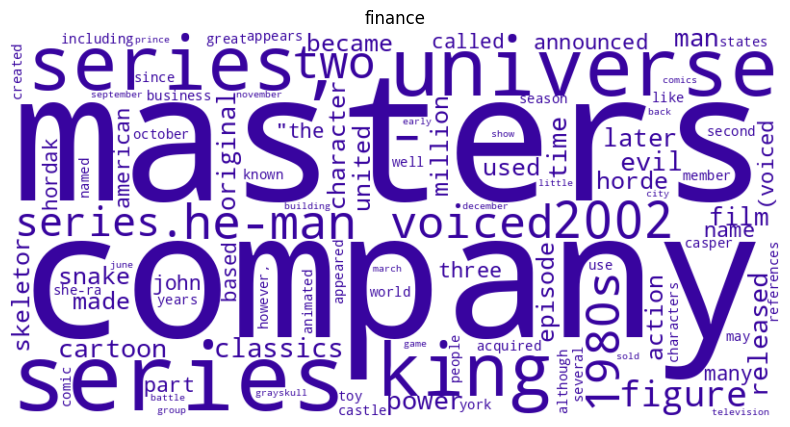

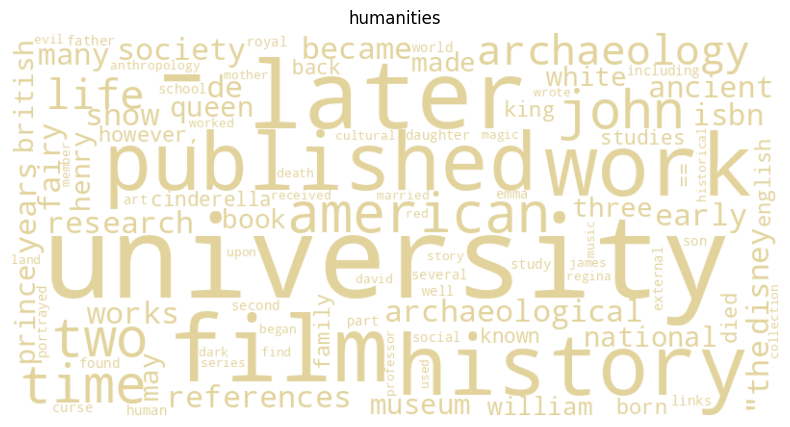

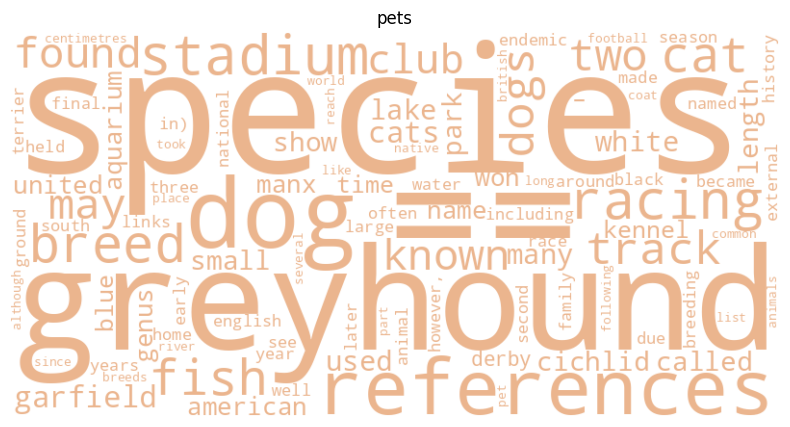

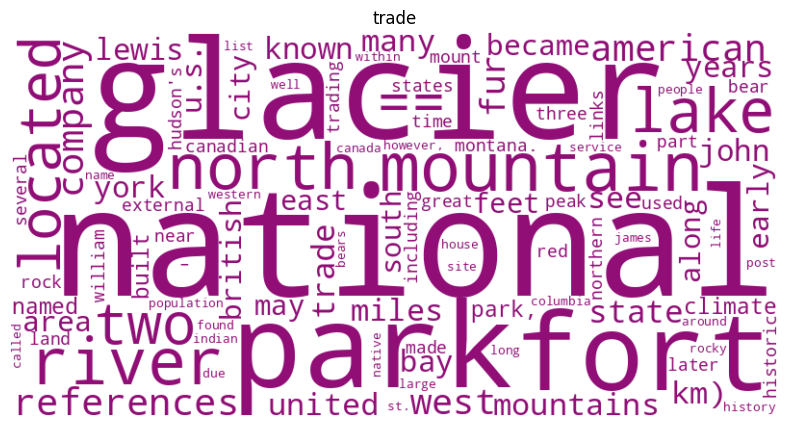

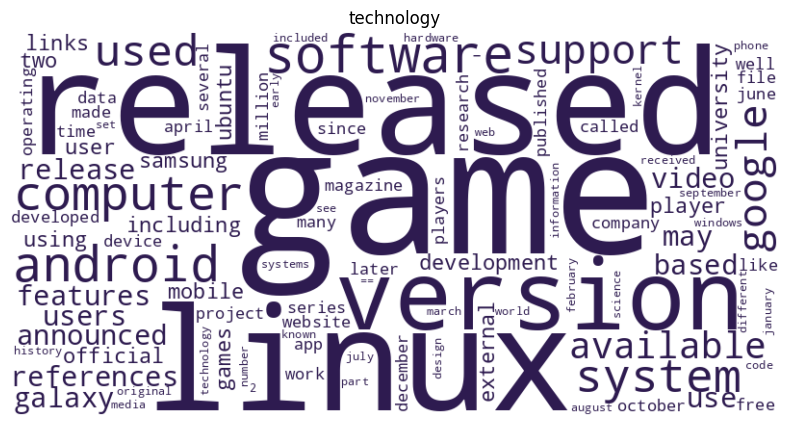

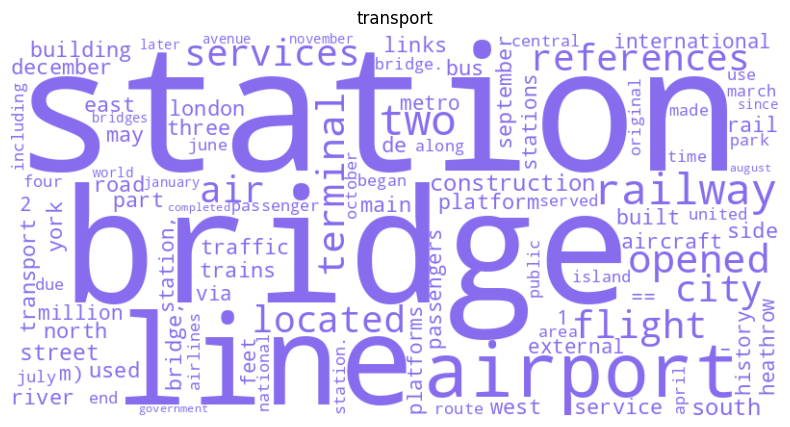

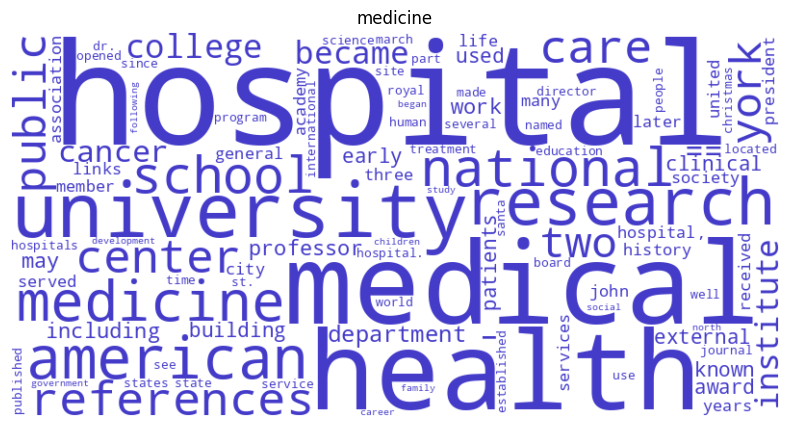

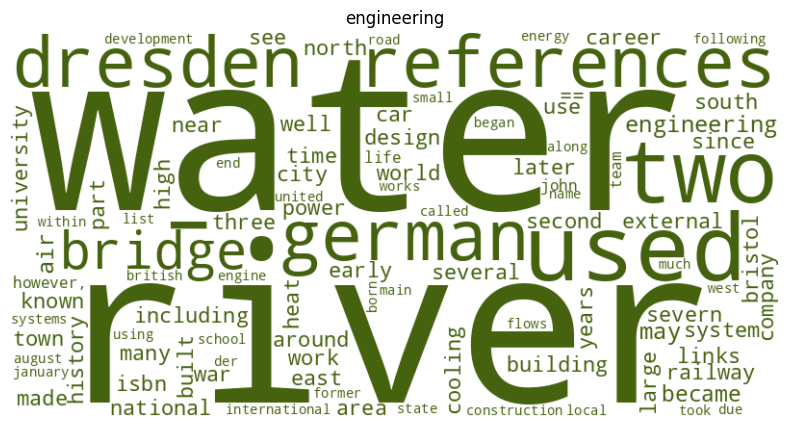

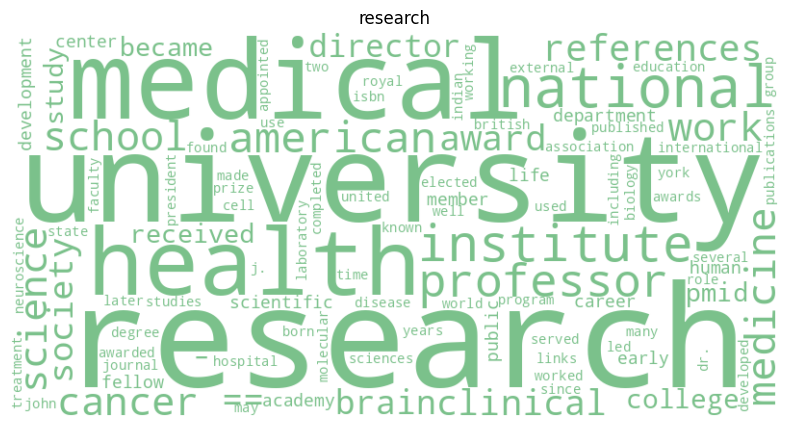

In [0]:
generate_wordcloud(spark_df, 'filtered_tokens_documents')

# -Classificatore di articoli
prova a fare tutto uguale ma rimuovere ogni colonna se non summary/documents e categoria

In [0]:
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, StandardScaler, PCA, StringIndexer
from pyspark.ml import Pipeline

In [0]:
#traformo la colonna "categoria" in una colonna "numerica"
indexer = StringIndexer(inputCol="categoria", outputCol="label")
indexer_model = indexer.fit(spark_df)
spark_df = indexer_model.transform(spark_df)

In [0]:
# a causa dei limiti di memoria lavoro su un dataframe composto dalle sole colonne di mio interesse: "summary" e "documents" assieme al target
 
summary_df = spark_df.select("filtered_tokens_summary", "label")

documents_df = spark_df.select("filtered_tokens_documents", "label")


In [0]:
# divisione in train e test dei due dataset
summary_train, summary_test = summary_df.randomSplit([0.8, 0.2], seed=1)
documents_train, documents_test = documents_df.randomSplit([0.8, 0.2], seed=1)


In [0]:
def create_pipeline(inputCol, labelCol, classifier) -> Pipeline:
    
    """    
    Funzione per creare un pipeline di PySpark ML.

    Questa funzione crea un pipeline che include le seguenti fasi: CountVectorizer, StandardScaler, PCA e un classificatore che va definito.

    Args:
        inputCol (str): Nome della colonna di input per il CountVectorizer.
        outputCol (str): Nome della colonna di output per il CountVectorizer.
        featuresCol (str): Nome della colonna delle caratteristiche per il classificatore.
        labelCol (str): Nome della colonna delle etichette per il classificatore.
        classifier (Classifier): classificatore di PySpark ML scelto.

    Returns:
        Pipeline: Pipeline di PySpark ML con le fasi specificate.
    """

    stages = [
        CountVectorizer(inputCol=inputCol, outputCol="counts", vocabSize=1000),
        StandardScaler(inputCol="counts", outputCol="scaled_raw_features"),
        PCA(k=100, inputCol="scaled_raw_features", outputCol="pca_features"),
        classifier(featuresCol="pca_features", labelCol=labelCol)
    ]
    return Pipeline(stages=stages)


In [0]:
def evaluate_model(model, test_data, labelCol="label", predictionCol="prediction", metricName="accuracy") -> float:
    """
    Funzione per valutare un modello di classificazione su un set di dati di test in PySpark.

    Questa funzione crea un oggetto MulticlassClassificationEvaluator, applica la trasformazione del modello ai dati di test e calcola la metrica specificata.

    Args:
        model (Classifier): Modello di classificazione di PySpark ML da valutare.
        test_data (DataFrame): DataFrame di PySpark contenente i dati di test.
        labelCol (str, optional): Nome della colonna delle etichette. Default a "label".
        predictionCol (str, optional): Nome della colonna delle previsioni. Default a "prediction".
        metricName (str, optional): Nome della metrica da calcolare. Default a "accuracy".

    Returns:
        float: Valore della metrica calcolata.
    """
    evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol=predictionCol, metricName=metricName)
    return evaluator.evaluate(model.transform(test_data))

## summary, LogisticRegression

In [0]:
#creazione pipeline
lr_pipe = create_pipeline("filtered_tokens_summary", "label", LogisticRegression)

In [0]:
#fitting
sum_lr_model = lr_pipe.fit(summary_train)

In [0]:
#performance (accuracy)
print("LR Model Accuracy: ", evaluate_model(sum_lr_model, summary_test))

LR Model Accuracy:  0.8001319696469812


## documents, LogisticRegression

In [0]:
#creazione pipeline
lr_pipe = create_pipeline("filtered_tokens_documents", "label", LogisticRegression)

In [0]:
#fitting
doc_lr_model = lr_pipe.fit(documents_train)

In [0]:
#performance (accuracy)
print("LR Model Accuracy: ", evaluate_model(doc_lr_model, documents_test))

LR Model Accuracy:  0.7969317057076872


# Esempi di utilizzo

In [0]:
from pyspark.sql import Row

def predict_custom_document(model, document, indexer_model) -> None:
    """
    Funzione per eseguire una previsione su un documento personalizzato.

    Args:
        model (Model): Modello di PySpark ML addestrato.
        document (str): Documento personalizzato su cui eseguire la previsione.
        indexer_model (StringIndexerModel): Modello StringIndexer addestrato.

    Stampa la previsione per il documento personalizzato.
    """
    # DataFrame con il documento personalizzato
    custom_document = spark.createDataFrame([Row(documents=document)])

    # pre-processing del testo
    custom_document = process_text_column(custom_document, "documents", "filtered_tokens_documents", "num_words_documents")

    # previsione
    prediction = model.transform(custom_document)

    # previsione più probabile
    predicted_label = prediction.select("prediction").first()[0]

    # categoria corrispondente all'etichetta
    categories = indexer_model.labels
    predicted_category = categories[int(predicted_label)]

    # Stampo la previsione
    print(f"Previsione: {predicted_category}")

In [0]:
#prova con un articolo sull'acqualcultura
doc = """ 
Background: Aquaculture is a millennial-old activity that has evolved slowly, often by building on traditional knowledge. Scientific progress in the twenty-first century brought unprecedented growth: production of aquatic animals in 2020 was more than 60% higher than the average in the 1990s,considerably outpacing world population growth, largely due to increasing aquaculture production. In 2020, fisheries and aquaculture production reached an all-time record of 214  million tonnes [1]. This stunning expansion presents several challenges that must be addressed
to achieve the final aim of sustainable farming [2]. Sustainable aquaculture relies on multiple factors, including
farmed fish, water quality, and feed formulations.
Considering the last aspect, replacing fishmeal with
alternative protein sources is a key objective to improve
sustainability in aquaculture and promote fish health.
Insects appear to be a valid alternative to fishmeal
because they are rich in nutrients, have a lower environmental impact than other plant-based protein sources,
and constitute part of the natural diet of fish [3–5].
One of the most commonly used species of insects in
aquafeeds is yellow mealworm (Tenebrio molitor). Different feeding trials have shown good growth in trout
(Oncorhynchus mykiss) fed diets with different levels of
FM substitution with T. molitor meal [6, 7].
Considerable research efforts have been made to evaluate novel feed formulations, focusing especially on the
effects on the fish gut microbiome. Indeed, the boost of
high-throughput DNA sequencing techniques (HTS)
has allowed an in-depth biodiversity analysis of microbial communities, generating unprecedented knowledge
about the composition of host-associated microbiomes,
especially gut microbiomes. However, for a deep and
extensive comprehension of aquaculture ecosystem
dynamics, this is not sufficient because many interactions link host-associated and environmental microbial
communities. Remarkably, there is still scarce information about the fish skin microbiome, which represents
the primary barrier in constant contact with the aqueous
environment, allowing the easy exchange of microbes
with the surrounding water. It is affected by both environmental and fish species-dependent factors [8–11].
Furthermore, fish skin biodiversity is negatively affected
by captivity, showing extensive shifts in microbial composition, with the environment and diet identified as
the major drivers of change [12]. A second neglected
contribution to aquaculture ecosystem health is that
of the environment, despite the well-documented role
of aquatic biodiversity in ecosystem equilibrium [13].
A recent study [11] evaluated how water and tank biofilm microbiomes influence the fish microbiome across
three mucosal environments (the gill, skin, and digesta).
The results of this study highlight how the aquaculture
environment is a unique source of microbes that colonize
fish and how this can influence fish health. Indeed, the
aqua culture facility itself represents a built environment
[14] that hosts its own microbiome, but further studies
are needed to use this knowledge to design the built environment and modulate the microbial communities that
are hosted for sustainable aquaculture.
Thus, recent scientific evidence suggests an interplay between different factors in aquaculture ecosystem
health. In this context, the effects of novel feed formulations on the microbiome at the water-fish interface are
poorly characterized. The purpose of this study was to
evaluate the influence of insect-based novel feed formulations on the environmental and fish microbiomes, and
therefore on fish health. This study comprehensively
considered feed, water, tank biofilm, fish cutis, and intestinal mucus microbiome to disentangle the microbial
structure at the water-fish interface in an engineered
ecosystem, such as an aquaculture plant. An enhanced
understanding of microbiome diversity and function in
high-value farmed fish species, such as rainbow trout is
required to sustain fish and environmental health.
Methods
Experimental design
Water, water tank biofilm, feed, skin mucus (hereafter
named “cutis”) and intestinal mucus (hereafter named
“mucus”) samples were collected from the experimental
fishery facility of the Department of Agricultural, Forest, and Food Sciences of the University of Turin (Italy),
located in Carmagnola (Turin, Italy).
Rainbow trout of 78.3±6.24 g mean initial weight were
randomly distributed into 400  L tanks (3 tanks/diet, 21
fish/tank). Tanks were supplied with untreated artesian
well water at the constant temperature of 13±1 °C, in a
flow-through open system (tank water inflow: 8 L/min).
The dissolved oxygen levels were measured every 2 weeks
and ranged between 7.6 and 8.7  mg/L, whereas the pH
was 7.5–7.6. A feeding trial was conducted for 22 weeks
(April - September 2018) with isonitrogenous, isolipidic,
and isoenergetic extruded experimental diets. Feed formulations consisted of increasing percentages of inclusion of partially defatted meal derived from T. molitor
larvae (diet B: 5% inclusion, 25% fish meal replacement,
diet C: 10% inclusion, 50% fish meal replacement, and
diet D: 20% inclusion, 100% fish meal replacement). In
control tanks, trout were fed with a diet without insect
meal (diet A). Main ingredients and proximate composition of the diets are described in [6] and detailed in Additional_file_1 - Supplementary Table S01. During the first
8 weeks, fish were fed at 1.6% of the tank biomass and
then, according to the fish growth and water temperature, the daily quantity of distributed feed was decreased
to 1.4%. Fish were fed twice a day (at 8 am and at 3 pm), 6
Bruno et al. BMC Microbiology (2023) 23:248 Page 3 of 17
days per week. Feed intake was monitored at each administration. In order to update the daily feeding rate, fish in
the tanks were weighed in bulk every 14 days. Mortality
was checked every day. The feeds were stored in a refrigerated room (6 °C) for the entire duration of the feeding
trial. Feeding and farming condition details are reported
in [6].
Water samples (1  L each) were collected in April,
June, and September 2018, corresponding to the initial, intermediate, and final phases of the trial, from
each tank and from the inlet (before entering the tanks)
(three replicates). Before environmental DNA extraction, water sample replicas of each feed formulation
were pooled and then 1 L of water was filtered by vertical (orthogonal) filtration using membrane filters with a
pore size=0.2 μm (47 mm diameter, nitrocellulose membrane filter, MilliporeTM). Regarding the third sampling
date, different porosity filters were used in series to cope
with the increased water turbidity and to retain inorganic
material (3 μm porosity, 47 mm diameter, nitrocellulose
membrane filter, Millipore™), and to trap most bacteria
(0.2  μm porosity, 47  mm diameter, nitrocellulose membrane filter, Millipore™). Moreover, we introduced a third
filtration step for those environmental bacteria that are
smaller in size than 0.2 μm and that filters normally used
do not retain (0.1 μm porosity, 47 mm diameter, polycarbonate membrane filter, Millipore™).
Water tank biofilm samples were collected at the end
of the trial (September 2018) from the internal surface of
each tank using sterile swabs, scraping the tank surfaces
on three different sides (dry swab, Gemini swabs and
Labware).
Water filters and biofilm swabs were then stored at
−20  °C until DNA extraction to preserve microbiome
integrity [15].
Skin and gut microbiota were collected as described
in a previous publication of our group [16]. However,
briefly, at the end of the trial, six fish/diet were sampled from the tanks in which trout were fed with diet A
(devoid of insect meal) and diet D (with 20% of insect
meal to replace 100% of fish meal). To obtain skin microbiota, the fish body was gently scraped using individually
wrapped sterile cotton swabs with plastic shafts, whereas
gut autochthonous microbiota was obtained by scraping
the mucosa of the entire intestine except for the pyloric
caeca. Samples were then processed using 200 µL of Xpedition Lysis/Stabilization Solution, as described in [17]
and stored at room temperature for up to 24 h until bacterial DNA extraction.
DNA extraction
All the instruments, if not disposable, were sterilized with
sodium hypochlorite or autoclaved before use. Pre- and
post-amplification phases were carried out in separate
rooms, and every step was conducted in a laminar flow
cabinet to avoid any possible contamination with exogenous DNA. We included negative controls to verify the
absence of contamination during DNA extraction steps.
Environmental DNA (water and tank biofilm) was
extracted from the filters obtained by water filtration
using a DNeasy® PowerWater® Kit (Qiagen, Italy), following the manufacturer’s protocol.
DNA from feed, cutis, and intestinal mucus samples was previously extracted by Terova et al. using the
DNeasyPowerSoil® Kit (Qiagen, Italy) [16].
Total DNA was checked for concentration and purity
using a Qubit 2.0 Fluorometer and a Qubit dsDNA HS
Assay Kit (Invitrogen, Carlsbad, California, United
States).
Library preparation and high-throughput DNA sequencing
The V3–V4 hypervariable regions of the 16S ribosomal
RNA (rRNA) gene were amplified with S-D-Bact-0341-bS-17, 5′-CCTACGGGNGGCWGCAG-3′ and S-D-Bact0785-a-A-21, 5′-GACTACHVGGGTATCTAATCC-3′
primer pairs with overhanging adapters, according to the
16S Metagenomic Sequencing Library Preparation protocol, Part # 15,044,223 Rev. B (Illumina, SanDiego, CA,
United States). Negative controls were used to verify the
absence of exogenous DNA contamination. The length
of the amplified DNA sequence was 550  bp. Amplicon
PCR products were checked using capillary electrophoresis with a QIAxcel Advanced System (Qiagen) to verify
the amplification and the correct length of the amplicon.
Index-PCR and Illumina MiSeq v3 2×300 paired-end
sequencing were carried out by “Center for Translational Genomics and Bioinformatics” (CTGB, San Raffaele Institute, Milan) in the case of water and tank biofilm
samples and at BMR Genomics (Padova, Italy) for all the
remaining samples.
DNA sequences analyses
Raw paired-end FASTQ reads were imported into the
Quantitative Insights Into Microbial Ecology 2 program
(QIIME2, ver. 2020.6) [18, 19], and demultiplexed native
plugins. Raw reads were subsequently deposited in the
European Nucleotide Archive (ENA) (see Data Availability paragraph). The Divisive Amplicon Denoising Algorithm 2 (DADA2) [20] was used to filter, trim, denoise,
and merge pairs of the obtained reads. The chimeric
sequences were removed using the consensus method.
The taxonomic assignment of the ASVs calculated
was carried out using the feature-classifier plugin [21]
implemented in QIIME2 against the SILVA SSU nonredundant database (138 release), adopting a consensus
confidence threshold of 0.8. Reads of mitochondrial or
eukaryotic origins were excluded.
Bruno et al. BMC Microbiology (2023) 23:248 Page 4 of 17
Rarefaction curves were calculated, and taxa-bar plots
were generated using the QIIME2 dedicated plugin taxa
[22].
To estimate the effect of the different sampling sources
and feed conditions on alpha diversity, the Observed
ASVs, Shannon Index, and Inverse Simpson Index [23,
24] were calculated. The Kruskal-Wallis H test for all and
pairwise tests were used to compare the groups. When
multiple tests were applied, we used the Benjamini and
Hochberg correction, and the obtained q-value was
reported in the text [25, 26].
To visualize the distribution of shared ASVs among different sample sources, we plotted a Venn diagram using
the VennDiagram R package.
We adopted an ordination approach to explore the
structure of microbial communities; specifically, we
used Non-metric Multidimensional Scaling (NMDS)
implemented in the phyloseq R package (McMurdie and
Holmes, 2013). Bray-Curtis dissimilarity [27] was used
to perform community analyses (beta diversity), evenly
sampled at 9000 reads per sample, using the core-metrics-phylogenetic QIIME2 plugin. Samples with less than
this threshold were excluded from downstream analyses.
Statistical significance among groups (sample source
and feed condition) was determined by the ADONIS
(permutation-based ANOVA, PerMANOVA) test [28]
with 1000 permutation-based Bray-Curtis. PerMANOVA
Pairwise contrast was performed, and the BenjaminiHochberg FDR correction was used to calculate q-values.
The test was performed using the beta group-significance
QIIME2 implemented plugin based on the adonis function in vegan R package [29].
A differential abundance analysis was carried out using
negative binomial generalized linear models [30] to estimate differences between groups considering the relative
abundance of ASVs assigned to the taxonomic rank of
the genus.
Water samples bacterial load and chemical analyses
Quantitative real-time PCR amplification assay (qPCR)
was performed with AB 7500 (Applied Biosystems) to
quantify bacterial DNA in water and tank biofilm samples and verify the absence of amplification reaction
inhibitors targeting the same 16S rDNA region chosen
for high-throughput DNA sequencing, as described in
[31]. Briefly, qPCR conditions included an initial denaturation at 95 °C for 10 min, followed by 40 cycles of denaturation at 95  °C for 15  s and annealing and elongation
at 55 °C for 1 min. The final dissociation stage was then
performed. Amplification reaction consisted of 5.0  µl
SsoFast EvaGreen Supermix with Low ROX (Bio-Rad
S.r.l., Italy), 0.1  µl each 10 µmol/L primer solution, 2  µl
DNA sample, and 2.8 µl of Milli-Q water. All samples and
negative controls (no template) were run in triplicates.
Threshold Cycle (Ct) values were converted to counts
(DNA copies) [31]. Statistical analyses were performed
using RStudio software version 1.0.44 (© RStudio, Inc.).
Data of the DNA counts were log-transformed, and a linear mixed-effects model (LME) was used, using the lme4
package [32], with the DNA counts as a response variable, while different tanks and sampling dates were taken
into consideration as fixed effects, and random effects
were the PCR replicates available for each sample. The
significance of the fixed variables was evaluated using the
drop1 function.
Heterotrophic cultivable bacteria were quantified in
each collected water. One milliliter of water was placed
on a solid non-selective nutrient medium (Plate Count
Agar, PCA). The growth occurred in duplicate at temperatures of 22 and 37 °C, and colony forming unit (CFU)
enumeration was carried out by visual observation,
according to D. Lgs. n. 31 of February 2, 2001 (implementing the European Directive 98/83/CEE) and after
seven days of incubation, to facilitate environmental bacterial growth.
For each water sample, total nitrogen, nitrites, nitrates,
ammoniacal nitrogen, and phosphate were measured
using a spectrophotometer (Spectroquant Pharo 300;
Merck). The pH and conductivity values were also
recorded. Analyses were performed using the following kits, according to the manufacturer’s instructions:
ammonium test photometric method NH4-N, nitrate test
photometric method NO3-N, nitrite test photometric
method NO2-N, total nitrogen test photometric method,
phosphate test photometric method PO4-P, and Merck
Spectroquant®. Statistical analyses were performed for
values>0 mg/L, using RStudio software (© RStudio, Inc.),
applying a linear model (LM), where the effect of the different tanks was tested (fixed effect) on the concentration
of the different chemical parameters (response variable),
using the lme4 R package [32]. The significance of the
results was assessed using the drop1 function.
Results
Water samples characteristics
The microbiological results of water samples are detailed
in Additional_file_1 - Supplementary Data S01, Additional_file_1 - Figures S01 and S02, Additional_file_1 -
Tables S02 and S03.
Chemical characteristics are reported in Additional_
file_1 - Supplementary Data S02, Figure S03, and Table
S04.
Overall, no significant differences in microbiological
and chemical parameters were recorded between the different feeding formulations. However, temporal variation
(considering sampling date) was reported when measuring nitrogen compounds and bacterial load by 16S
rRNA gene qPCR assay. The bacterial load on the third
Bruno et al. BMC Microbiology (2023) 23:248 Page 5 of 17
sampling date was significantly higher than that on the
first and second sampling dates. Nitrate and total nitrogen concentrations showed significant variations in September 2018 and April 2018, respectively.
High-throughput DNA sequencing analysis
A total of 61 samples (15 water samples, 14 tank biofilm samples, 12 gut mucus samples, 12 cutis samples,
and 8 feed samples) were analyzed to explore their
microbiomes.
From the high-throughput DNA sequencing of the
hypervariable regions V3-V4 of the 16S rRNA gene, after
quality filtering, merging reads, and chimera removal of
the two Illumina runs, we obtained 6,105,976 sequences,
with a median frequency of 64,547 reads per sample. We
obtained 12,798 ASVs (amplicon sequence variants, [33]
and in order to clean the data from spourius ASVs, a
subset to min 50X reads per ASV was created, obtaining
2948 ASVs.
Considering the reads distribution among samples,
water samples had the highest number of reads (even
without considering INST_A, which had an exceptional
number of reads), followed by tank biofilm samples, and
feed samples had the lowest (Additional_file_1 - Supplementary Fig. S04).
Microbiome diversity composition and distribution
Microbiome biodiversity and composition were evaluated considering different sample sources and feed
conditions.
Two samples (236032F221730: feed D; T-01  C: tank
biofilm A) were removed from subsequent analyses
because of their low number of reads (8919 and 141,
respectively).
Three main indices were calculated to describe the
diversity within the samples (alpha diversity) for each
sample source: the Observed ASVs, Shannon index, and
Inverse Simpson index (Fig. 1).
Considering all the metrics, water samples, in particular inlet water, showed the highest alpha diversity, followed by tank biofilm samples. The lowest alpha diversity
was measured in the mucus and feed samples (Fig.  1).
Considering all different sample sources, the KruskalWallis H test was significant (p<0.05).
Taxonomy proportions assigned to the ASV were 97%,
96%, 89%, 77%, and 56% for the taxonomic ranks of Phylum, Class, Order, Family, and Genus, respectively. Taxonomic analysis revealed that most of the sequences in all
samples were associated with the phyla Proteobacteria
(53.5%), Bacteroidota (18.9%), and Firmicutes (17.5%).
Looking inside the class rank, we found members mainly
belonging to Gammaproteobacteria, Bacteroidia, and
Bacilli (44.5%, 18.9%, and 14.7%, respectively). Concordantly, the three most abundant families reported were
Mycoplasmataceae (Firmicutes), Comamonadaceae
(Proteobacteria), and Flavobacteriaceae (Bacteroidota)
(11.9%, 10.7%, and 8.2%, respectively) (Additional_file_2
- Supplementary Data S03).
The top five genera assigned were Mycoplasma (Firmicutes), 11.9% reads; Flavobacterium (Bacteroidia),
8.2% reads; Pseudomonas (Proteobacteria), 5.6% reads;
Fig. 1 Alpha diversity boxplot for sample sources, considering the Observed ASVs, Shannon Diversity Index, and Inverse Simpson Index
Bruno et al. BMC Microbiology (2023) 23:248 Page 6 of 17
Acinetobacter (Proteobacteria), 5.4% reads; and Rheinheimera (Proteobacteria), 5% reads. Notably, we reported
the presence of Gracilibacteria (class rank, Patescibacteria phylum) and Cyanobacteria (phylum rank) in all sample sources except for feed and mucus, regardless of the
feeding administered.
Bar chart representation highlights the distribution
of sequences across samples, assigned to the taxonomic
rank of the Family (Fig. 2).
The distribution of shared ASVs among the different
sample sources is shown in the Venn diagram (Fig. 3).
Eight ASVs were shared by all samples, assigned to
the genera Cutibacterium, Streptococcus, Mycoplasma,
Methylobacterium-Methylorubrum (uncultured bacterium), Acinetobater, Aeromonas, and Enhydrobacter
(uncultured bacterium).
Notably, mucus samples had only one unique ASV, in
contrast to the water samples, which had 1136 exclusive
ASVs. The tank biofilm and water samples shared 1227
ASVs. The cutis and water samples had in common 601
ASVs. 37 ASVs were shared between the mucus and
water samples.
Notably, a single ASV, assigned to the genus Mycoplasma, was retrieved (with >800 reads) from 35 samples, all belonging to cutis and mucus samples.
Core microbiome analyses
The core microbiome was calculated considering samples
per feed formulation and assigned at the taxonomic rank
of the genus. In the case of both feed formulation A (control) and feed formulation D samples, Aeromonas was the
only genus shared by at least 90% of the samples, regardless of the sample source. In 80% of the samples characterized by feed formulation A, the shared genera were
Aeromonas, Mycoplasma, Acinetobacter, and Pseudomonas, whereas in the case of formulation D, they were
Aeromonas and Mycoplasma, regardless of the sample
source.
Microbial community analyses
The abundance of each ASV within and across samples
is shown with a heatmap (Additional_file_1 - Supplementary Fig. S05). Interestingly, patterns of abundance were
also observed. For instance, feed samples showed a high
abundance of ASVs assigned to Lactobacillus, Streptococcus, Photobacterium, and Weissella (Lactobacillales),
all Gram-positive bacteria with the exception of Photobacterium. Mycoplasma was found to dominate in the
cutis and mucus samples. A cluster of ASVs was more
abundant in water and tank biofilm samples and was
assigned to Sphaerotilus (Burkholderiales), Bacteroidetes bacterium OLB8, Hydrogenophaga (Burkholderiales),
Fig. 2 Bar chart depicting the relative abundance and distribution of the 30 most abundant bacterial families. Each bar represents a sample, and the
y-axis indicates the relative abundance (from 0 to 100%)
Bruno et al. BMC Microbiology (2023) 23:248 Page 7 of 17
Haliscomenobacter (Chitinophagales), Rhodoferax (Burkholderiales), Phreatobacter (Rhizobiales), and other
uncultured bacteria.
According to the NMDS plot drawn on Bray-Curtis
dissimilarity, samples were clustered based on their
source. Feed samples clustered together and were clearly
separated from the other groups as well as cutis, mucus,
water, and tank biofilm samples. No complete overlap
was observed between the water and tank biofilm samples (Fig. 4).
Paired ADONIS (1000 permutations) results showed
that significant differences existed among the different
sample sources (Additional_file_1 - Supplementary Table
S05).
Considering the different feed formulations for each
type of sample (“sample type”), no significant difference
was observed (but higher differences were observed
Fig. 4 NMDS based on the Bray-Curtis metric considering the sample source
Fig. 3 Venn diagram representing shared ASVs among sample sources
Bruno et al. BMC Microbiology (2023) 23:248 Page 8 of 17
between feeding formulations for feed and mucus samples) (Additional_file_1 - Supplementary Table S06).
Moreover, the NMDS plot of taxa distribution across
samples showed that some phyla were differentially distributed according to the sample source (Additional_
file_1 - Supplementary Fig. S06). Indeed, if Firmicutes
and Proteobacteria were found in almost all samples,
regardless of the sample source, Patescibacteria, Myxococcota, Nitrospirota, and Verrucomicrobiota were
typical of water and tank biofilm samples. Bacteroidota
were found in all sample sources, but not in the mucus
samples.
Network analyses
The construction of a network analysis (based on BrayCurtis dissimilarity) allowed us to highlight whether any
correlation existed among different sample sources and
sample types (Fig. 5).
The network displayed a structure with a major subgraph comprising the majority of the samples and a
minor subgraph made using only feed samples. Furthermore, a correlation between the samples belonging to
cutis and mucus, on the one hand, and water and tank
biofilms, was highlighted within the network. Different feeding formulations were not the drivers of the
correlations.
Differential abundance analysis
Thus, to deepen the analysis and disentangle any contribution of feeding formulations at a finer scale, a differential abundance analysis was carried out using negative
binomial generalized linear models.
A sample subset was used, in order to compare the
effect of different feeding formulation for each sample source, thus comparing “CUTIS_A”, “CUTIS_D”;
“FEED_A”, “FEED_D”; “MUCUS_A”, “MUCUS_D”;
“WATER_A”, “WATER_D”;“TANK BIOFILM_A”, “TANK
BIOFILM_D”, and accounting for 46 samples and 2948
taxa (Table 1; Fig. 6).
Overall, we found that control (feed formulation A)
samples had a higher number of genera with a positive
differential abundance compared to those related to feed
formulation D.
Table 1 Differential abundances of genera among different
sample sources and feeding formulation groups (A vs D)
Genus Group A Group D
Acinetobacter mucus, tank biofilm feed
Kluyvera mucus
Citrobacter mucus, water tank biofilm
Rivicola mucus, cutis
Lelliottia mucus, cutis
Flavobacterium mucus
Aeromonas mucus mucus
Methylobacterium mucus
Rheinheimera cutis
Pseudomonas cutis, water, tank biofilm
Deefgea cutis tank biofilm
Pseudoxanthomonas cutis
Exiguobacterium cutis
Raoultella cutis
Chryseobacterium water
Comamonas water
Ca. Amoebophilus tank biofilm
Rhodococcus tank biofilm
Fig. 5 Network graph based on the Bray-Curtis dissimilarity. Sample types are shown
Bruno et al. BMC Microbiology (2023) 23:248 Page 9 of 17
Considering the feed samples, only one ASV assigned
to the genus Acinetobacter (Proteobacteria; Gammaproteobacteria; Pseudomonadales; Moraxellaceae) showed a
significant differential abundance compared to feed formulations A and D, being more abundant in D.
Citrobacter and Deefgea revealed to be significantly
more abundant in the biofilm of the tank where feed
formulation D was administered, but significantly more
abundant in the mucus, water (Citrobacter), and cutis
samples (Deefgea) related to feed formulation A.
On the other hand, when we compared the two different water sample sources, namely tank biofilm and
water samples, for the two feeding formulations (A and
D), we observed a higher number of genera that were significantly more abundant in water than in tank biofilm
samples for both feeds administered. Moreover, in tanks
where feed formulation A was administered, the number
of genera that varied positively was higher than that in D
(Fig. 7).
To evaluate the enrichment of specific taxa, if any, in
tank water compared to inlet water (before entering the
tank), the differential abundance of ASVs, assigned at the
genus level, was also calculated. To do so, we included all
the feeding formulations investigated in the case of water
samples (A, B, C, and D) (Fig. 8).
Overall, we counted 65 genera that showed a significant difference in relative abundance compared to inlet
and tank water, with most genera falling in the tank water
group. This was true irrespective of the feeding formulation administered.
Discussion
A significant challenge for sustainable aquaculture is
maintaining a low footprint in the environment and
profit farming [2]. Insect-based novel feed formulations
are promising solutions and in our case study, we had the
opportunity to investigate the effects of full replacement
of dietary fishmeal with insect meal from Tenebrio molitor on rainbow trout farming.
Fig. 6 Differential abundance of ASVs (assigned at the genus level) in cutis, feed, mucus, tank biofilm, and water samples considering feed formulation
D vs feed formulation A
Bruno et al. BMC Microbiology (2023) 23:248 Page 10 of 17
Taking advantage of the previous data collected in the
same trial of rainbow trout gut and skin microbiome [16],
we analyzed together the microbial communities characterizing water, tanks, feed, and fish cutis and gut mucus
using high-throughput DNA sequencing techniques.
Changes in aquaculture-related microbiomes have an
impact on farm and animal conditions and performance,
which often tips the balance between farm profit and
failure.
Here, we discuss the results first focusing on the environment-associated and host-associated microbiomes
and then in the light of aquaculture as a holobiome.
A focus on water ecosystem and the aquaculture built
environment
Despite an array of studies evaluating fish gut microbiomes and health, there is a lack of information on how
the microbiome of the built environment contributes to
fish health and aquaculture system equilibrium. The built
environment encompasses all the environments that
humans have constructed, including buildings, cars, public transport, other human-built spaces [14], and aquaculture plants [11, 34]. Built environments harbor unique
microbial communities, different from those found in
other environments on Earth. The aquaculture plant
investigated in this study is an experimental-scale facility that uses groundwater to farm fish in a flow-through
open system.
Thus, natural (groundwater) and constructed (aquaculture plant) environments are interconnected. In the
flow-throw open system, the flow has a direction from
the water upstream to the downstream tanks, where fish
are farmed, and feed is administered.
In our study, we collected water samples from three
different sampling dates, at the beginning, at the intermediate phase, and at the end of the trial. We had the
opportunity to sample inlet water (before entering the
tanks) and water tanks for the control diet (A) and diet
with 100% substitution with insect meal, but also diets
with increasing percentages of substitution level (B: 25%
and C: 50%). Overall, the microbiological and chemical
characteristics recorded in our study showed high-quality water, with low ammonia levels and no diseased fish
along the trial.
No significant differences were recorded between the
different feeding formulations administered, proving that
substitution with an insect-based meal does not affect
water quality. An exception is represented by the bacterial load measured by heterotrophic plate count at 22 °C,
which was significantly lower in tanks where formulation
Fig. 7 Differential abundance of ASVs (assigned at the genus level) in water and tank biofilm samples considering feed formulations A and D
Bruno et al. BMC Microbiology (2023) 23:248 Page 11 of 17
D was administered (full replacement of fish meal with
T. molitor larvae meal) compared to formulation A (control). Moreover, as expected, the inlet water showed a significantly lower number of CFUs (both grown at 22 and
37 °C) than tank water, irrespective of the sampling date.
Nevertheless, temporal variation (considering sampling
date) was reported when measuring nitrogen compounds
and bacterial load by 16S rDNA qPCR assay. The bacterial load on the third sampling date was significantly
higher than that on the first and second sampling dates.
Marmen et al. [35] demonstrated that the structure of the
aquatic bacterial communities in the aquaculture system
investigated was explained primarily by natural seasonality, whereas aquaculture-related parameters had only a
Fig. 8 Differential abundance of ASVs (assigned at the genus level) in inlet (before entering the tank) and tank water samples considering feed formulations A, B, C, and D
Bruno et al. BMC Microbiology (2023) 23:248 Page 12 of 17
minor explanatory power. However, in our case study, we
cannot say if this may be due to the time passed from the
beginning of the trial and/or a seasonality effect, considering that the first sampling date was in spring and the
last at the end of summer. The discrepancy between the
bacterial load measurements assessed via culture-based
methods and DNA-based methods is not unexpected,
since the former provides evidence of metabolically
active heterotrophic bacteria, whereas the latter detects
the DNA of both live and dead bacteria, culturable or
not. Thus, these complementary methods suggest that
there is a driver of changes that can be seen on the sampling date, but also that differences in microbial taxa may
exist for different tanks.
In line with other recent studies [34], the overall composition of the water community from the natural source
spring through to the outflow from the farm was stable
and not significantly different despite variations in water
quality parameters among sampling dates. Overall, water
showed astounding microbial diversity compared to
host-associated and feed samples, and considering all the
alpha diversity metrics tested, water samples, in particular inlet water, had the highest alpha diversity, followed
by tank biofilm samples. This is not surprising, as growing evidence has reported the unique microbial biodiversity of water, spanning from natural to artificial aquatic
ecosystems and from freshwater to marine resources
[36–39].
The beta-diversity analyses highlighted how the microbial communities characterize sample sources, differentiating water-related samples (water and tank biofilm) from
host-associated (cutis and gut mucus) and feed samples.
At this point, we wondered whether differences in the
abundance of specific taxa existed in the inlet source
water and water present in the rearing tanks. Notably,
we reported a higher number of genera that significantly
increased in relative abundance in tank water than in
inlet water. Although they represent preliminary results,
given the low number of inlet water samples, they suggest
a contribution of farmed fish in shaping the structure of
microbial communities in terms of the abundance, and
presence/absence of specific taxa.
Many of the genera differentially abundant are typical
of freshwater ecosystems, such as Tabrizicola (Rhodobacteraceae), previously described as a purely chemotrophic, with chlorophyll-dependent phototrophy recently
included in the description [40]; Rudanella (Spirosomaceae) found in air and activated sludge samples [41]; the
methylotrophic Methylotenera (Methylophilaceae), first
isolated from Lake Washington sediment [42].
Nevertheless, when we investigated the microbial communities harbored by water in tanks considering different
feeding formulations, we observed significant differences
in the abundance of specific taxa.
Chryseobacterium species (Weeksellaceae) were significantly more abundant in the tank water samples where
the control diet (A) was administered. These chemoorganotrophic bacteria can be recovered from different
environments (soil, freshwater, drinking water, lactic acid
beverages, marine sediment and permafrost) and are
associated with a multitude of animals (midgut of mosquitoes, cockroach guts, millipede feces, penguin guano,
gut homogenates of freshwater copepods, bird feathers, cow’s milk, raw meats, and chicken) [43–46]. Chryseobacterium spp. have been recovered from the mucus
of apparently healthy fish; however, they are sometimes
considered spoilage organisms [47]. In our study, Chryseobacterium sequences were also highly abundant in the
cutis samples.
The higher abundance of Citrobacter in water sample A
(also detected in tank biofilm D and mucus A) deserves
note, especially in light of the interplay between hostassociated and environmental microbial communities.
Citrobacter is a genus of gram-negative coliform bacteria in the family Enterobacteriaceae that can be found
in soil, water, and wastewater but is also associated
with fish. C. freundii strains have inducible ampC genes
encoding resistance to ampicillin and first-generation
cephalosporins. In addition, isolates of Citrobacter may
be resistant to many other antibiotics because of their
plasmid-encoded resistance genes [48]. Thus, monitoring Citrobacter in different compartments of aquaculture
plants may be an advisable strategy.
In tank biofilms, Acinetobacter, Pseudomonas, Rhodococcus, and Candidatus Amoebophilus were significantly more abundant when feeding formulation A was
administered. Interestingly, Ca. Amoebophilus (Cytophagales; Amoebophilaceae) is likely to be a symbiont of
the amoebae. Free-living amoebae, such as Acanthamoeba spp., are ubiquitous protozoa that can be found in
diverse habitats, such as soil, marine water, freshwater,
and in many engineered environments. Ca. Amoebophilus was recorded only in water and tank biofilm samples.
Conversely, the evidence that Citrobacter was found to be
more abundant in tank biofilm samples belonging to feed
formulation D (and in water A, as mentioned previously)
suggests that it is not dependent on the feed formulation administered, but on other conditions still undefined. Deefgea were also found to be significantly more
abundant in tank biofilm D. The presence of Deefgea in
O. mykiss facilities is in line with previous studies that
detected this bacterium in the gut and cutis of rainbow
trout ([49] and [16] respectively), suggesting water-fish
exchange and interconnection.
Supporting our evidence, the study of Minich et al. [50]
highlighted the role of the microbiome in the aquaculture
environment, analyzing tank water, tank side, inlet water
pipe, air stones, and air diffusers along with the feed
Bruno et al. BMC Microbiology (2023) 23:248 Page 13 of 17
used. Furthermore, they proposed that the aquaculture
built environment may originally be colonized by animal
excrement, including mucus, along with environmental sources, such as water, with their peculiar microbial
communities. The built environment microbiome can
influence the microbial communities of the animal hosts
residing there. Understanding the extent to which an animal’s microbiome can be influenced by its surroundings
and then associated with a phenotype, such as fish health,
will be important for experimental design where microbiome readout is a standard measure.
Host-associated microbial communities
Both intestinal and skin microbial communities are
important for preserving host health. In humans, several
studies have demonstrated a bidirectional link between
gut dysbiosis and an imbalance in skin homeostasis [51].
Unlike the fish gut microbiome, which has been widely
investigated over the last decade in both marine and
freshwater species, our knowledge of the skin microbiome remains limited. Fish skin harbors a complex and
diverse microbiota that is in constant contact with the
external environment (water), which is more susceptible
to changes than the gut environment [52].
In the present study, the skin microbial community
compositions of dietary groups A and D displayed clearly
distinctive features. In accordance with previous studies in fish, the skin microbiome differed markedly from
the bacterial communities in the surrounding water [52,
53], except for the Pseudomonas genus, which was highly
abundant in the skin, water, and tank biofilms of the control group.
At the genus level, trout fed insect meal showed a
decrease in the relative abundance of Rheinheimera,
Pseudomonas, Deefgea, Pseudoxanthomonas, Exiguobacterium, and Raoultella. All of these, with the exception of
Exiguobacterium, belong to the phylum Proteobacteria.
In general, Proteobacteria is the predominant phylum in
the fish skin microbiome; in particular, Gammaproteobacteria class is dominant in the skin of teleosts living in
temperate waters, including trout [10, 16, 54]. A decrease
in Proteobacteria and specifically Deefgea genus in the
skin-associated microbiome confirmed our previous
findings in trout fed T. molitor larvae meal [16]. Deefgea
is a member of the family Neisseriaceae and it has been
detected in both healthy and unhealthy fish [55]. Unfortunately, little information relating to Deefgea is available
since only two species belonging to this genus have been
isolated so far, i.e., Deefgea rivuli and Deefgea chitinilytica [56, 57]. Because several other bacterial taxa from the
Neisseriaceae family have been described to be chitinhydrolyzing species, it is suspected that D. chitinilytica
has a similar function as well. This raises the question of
whether the presence of chitinolytic bacteria at the skin
level can cause diseases such as lesions of the shrimp exoskeleton, which mainly consists of chitin. For this reason,
Deefgea may have an important role, and has been listed
among opportunistic taxa that may be involved in skin
infections of aquatic organisms.
In contrast, Pseudomonas species are opportunistic
bacteria that are naturally resistant to the beta-lactam
group of antibiotics and are responsible for septicemic
diseases among freshwater fish. Therefore, the decrease
in the skin mucus of trout fed with insect meal was a
desirable effect. Recent studies have reported that insect
meal may influence the immune system of fish at the
epidermal mucus level [58, 59]. Interestingly, in a study
by Hidalgo et al. [59], an increase in alkaline and acid
phosphatase activity was detected in the skin mucus of
tenches (Tinca tinca) fed different types of insect meal,
including Tenebrio molitor meal. Since both enzymes are
commonly present in the epidermal mucus of fish and
have bactericidal activity [60], it was hypothesized that
the fish immune system could have been indirectly stimulated by chitin or by other insect components, such as
lauric acid [61].
Similarly, at the gut mucosa level, T. molitor meal
inclusion in the diet led to a significant reduction in gut
Proteobacteria, predominantly belonging to the class
Gammaproteobacteria. In line with our previous studies,
the abundance of Citrobacter and Kluyvera genera was
significantly reduced in the resident intestinal microbiome of trout fed insect meal, whereas the relative abundance of Aeromonas was not affected by diet [16, 62]. The
presence of Citrobacter genus, as mentioned in the previous paragraph, is worth mentioning, since it includes
potential pathogen species, such as C. freudii and C.
braakii, which are Gram-negative bacteria responsible for
gastroenteritis and hemorrhagic septicemia in rainbow
trout and cyprinids. Furthermore, with respect to the
control fish group, feeding insect meal resulted in lower
abundance of the Acinetobacter genus, another potential
pathogen in aquaculture, commonly known as a microorganism that transmits the antibiotic resistance genes.
Fish mortality caused by several Acinetobacter species,
such as A. baumannii, A.lwoffii, A. johnsonii, and A. calcoaceticus, has been well documented in rainbow trout
[63] and this genus has been classified as harmful for fish
intestine. Similarly, Flavobacteria, a group of commensal bacteria and serious fish pathogens, were adversely
affected by an insect-based diet. Flavobacterial diseases
in fish are caused by multiple species within the family
Flavobacteriaceae, and they are responsible for devastating losses in farmed fish stocks. In the case of acute flavobacteriosis, the mortality rate can be as high as 70%, and
survivors may suffer poor growth and spinal abnormalities [64]. For instance, Flavobacterium psychrophilum is
the etiological agent of coldwater disease and rainbow
Bruno et al. BMC Microbiology (2023) 23:248 Page 14 of 17
trout fry syndrome, which cause 50% or greater mortality
[65]. Therefore, our findings on the intestinal-associated
microbiome indicate that feeding trout with insect meal
has a positive effect by inhibiting the growth of potential
gram-negative bacterial pathogens.
Aquaculture as a holobiome
One of the key points of aquaculture ecosystem health
is microbial diversity, with HTS technologies increasing
our understanding of the role microorganisms play in
the health of the ecosystem and hosts. A better understanding of microbial–host interactions will help avoid or
manage dysbiosis in aquaculture systems, with the final
aim of improving productivity. One of the crucial aims of
this study was to investigate shifts in microbial diversity
across aquaculture ecosystems.
The inlet water represents the background microbial
community entering the tanks. Feed is constantly administered to fish in the tank, carrying out its own microbial contribution. Water is the connection between the
surface of the tank (biofilm) and the fish (cutis and gut
mucus). All the analyses carried out, spanning from the
Venn diagram to alpha diversity and differential abundance analyses, converged in one of the hallmarks of
aquatic ecosystems: extreme biodiversity, compared to
mucus and feed, which are the least diverse. It is well
documented that OTU richness and phylogenetic diversity are higher in healthy water environments [66–68]
and increasing evidence supports the fact that the waterassociated bacterial microbiome is commonly more
diverse (alpha-diversity) than the vertebrate and invertebrate host-associated microbiome [69, 70], showing a
clear host-associated selective pressure on the bacterial
community.
Considering all the samples collected, only eight features were shared among the different sample sources,
and core microbiome analysis revealed the presence
of a highly reduced core composed of Aeromonas spp.
Other studies on the ecology of aquaculture systems have
attempted to identify a core microbiome, but they are still
not conclusive [71]; however, on a broader scale, freshwater fish have been shown to harbor a high abundance
of Aeromonas species, whereas the intestinal microbiome of marine fish is dominated by the genus Vibrio [72].
Aeromonas are known inhabitants of aquatic environments; therefore, fish are common sources for isolating
these microorganisms. They are recognized as emerging pathogens because they colonize the host and cause
diseases. However, contact with fish and other aquatic
animals develops in a continuous and almost inevitable
manner and this does not necessarily evolve in pathogenesis [73].
Through network analysis, we showed that the major
driver of the microbial community structure is the
sample source, with the main differences detected
between environmental and host-associated samples.
Thus, the different feed formulations did not seem to
affect the environment (water and tank biofilm) or fish
(cutis and gut mucus). Nevertheless, it was only looking
at finer differences (the differential abundance analysis)
that it was possible to reveal an enrichment/impoverishment in specific taxa by comparing the samples belonging to the control diet (A) and the samples belonging to
the insect-based diet (D).
The increased interest in insects is related not only to
their use as raw materials for feed formulation but also
as food, as described in more than 150 research papers
published on this topic over the last few years (for a
review see [74]). This high number of publications represents an indicator of the great potential of insects as
feed and food, as well as the need to steer Westerners
toward insect-based food acceptance [75]. Furthermore,
insect-based feed and food contribute to the microbial
community, with marked variations in microbial load and
diversity, as well as stable and species-specific microbiomes for some of the most popular edible insect species,
such as T. molitor [76, 77].
In different contexts, microbial communities have been
proposed as valuable signatures [78], peculiar to specific
ecosystems and conditions. Thus, such microbial signatures can be exploited to predict the changes occurring
in the microbial consortia over time, their role, and their
effects on the environment and on the hosts, and therefore on human health.
Our research highlights the interconnection between
the environment microbiome and the host-associated
microbiome. It proposes the potential of tuning microbiota composition using innovative raw materials like
insect meal, as a promising approach for sustainable
aquaculture. The results hold significance for researchers
and aquaculture experts, as they provide valuable insights
for developing healthy and sustainable aquaculture practices, particularly when formulating new feeds.
Consequently, a broader understanding of aquaculture ecosystems as holobiomes is necessary to drive the
sustainability of fish and environmental health. In the
realm of Global Health concepts towards sustainability in aquaculture, contemporary studies are in favor of
environmental biodiversity that encourages more diverse
microbiomes [79, 80], eventually resulting in a more
resilient system and healthier farmed species. Such studies will pave the way for sufficient knowledge to modulate
the microbiome in artificial ecosystems.
Conclusions
Understanding how the aquaculture microbiome is
shaped is rather challenging, owing to the complexity
of microbial community assembly, but it is pivotal for
Bruno et al. BMC Microbiology (2023) 23:248 Page 15 of 17
efficient and sustainable farming. Sustainable aquaculture
requires the replacement of FM with novel feed formulations. However, most research efforts have focused on
the effects on fish growth and the fish gut microbiome.
Water plays a crucial role in connecting the surfaces of
this peculiar built environment, that is, the tank (biofilm)
and fish (cutis and intestinal mucus). Omic exploration of
the water-fish interface exposes patterns otherwise undetected. The research presented here offers a step toward
modulating the aquaculture environment and its microbiome for beneficial outcomes.
"""

In [0]:
# Utilizzo della funzione
predict_custom_document(doc_lr_model, doc, indexer_model)

Previsione: engineering
